#### 이탈 고객 예측

#### 데이터 전처리(결측치처리, 클래스 불균형 확인 및 처리)
#### 특성공학 - 피처선정 또는 피처생성
##### 베이스 모델선정
    - 분류모델 : LogisticRegression
    - 클래스 리포트, 과적합여부
##### 베이스 모델의 성능을 상회하는 모델과 하이퍼 파라메터 조합을 찾아서 성능을 출력

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

In [7]:
url = 'https://raw.githubusercontent.com/pia222sk20/python/refs/heads/main/data/tellecom.csv'
data = pd.read_csv(url)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
data.shape

(7043, 21)

In [9]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


<Axes: >

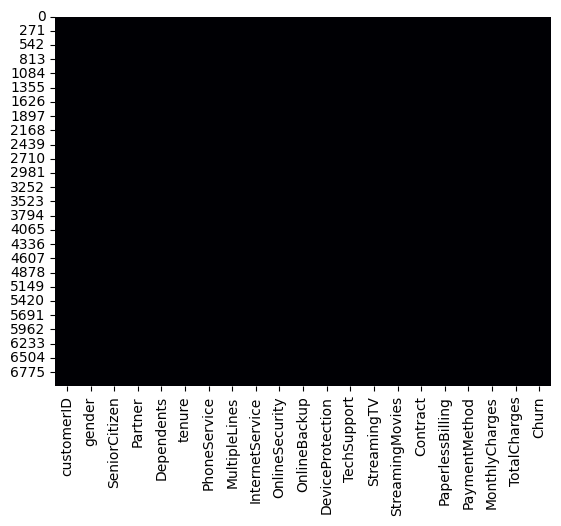

In [11]:
sns.heatmap(data.isnull(), cmap = 'magma', cbar=False)

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.00,0.16,0.37,0.00,0.00,0.00,0.00,1.00
tenure,7043.00,32.37,24.56,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.00,64.76,30.09,18.25,35.50,70.35,89.85,118.75


In [13]:
'''
이 데이터셋에는 텍스트 형태의 데이터가 많은 특성(컬럼) 이 있으며, 이들은 아마도 범주형(feature) 일 가능성이 높습니다.
Total Charges 특성은 숫자형 값을 가지고 있지만, 현재 문자열(string) 형태로 저장되어 있습니다.
따라서, 먼저 이 열을 실수(float) 형으로 변환하겠습니다.
'''

l1 = [len(i.split()) for i in data['TotalCharges']]
l2 = [i for i in range(len(l1)) if l1[i] != 1]
print('Index Positions with empty spaces : ',*l2)

for i in l2:
    data.loc[i,'TotalCharges'] = data.loc[(i-1),'TotalCharges']

data['TotalCharges'] = data['TotalCharges'].astype(float)
data.drop(columns = ['customerID'], inplace = True)

Index Positions with empty spaces :  488 753 936 1082 1340 3331 3826 4380 5218 6670 6754


In [14]:
# TotalCharges 열을 float(실수형) 으로 변환하는 과정에서
# 문자열을 숫자로 변환할 수 없다는 오류가 발생했습니다.

# 이 오류는 TotalCharges 열에 빈 문자열(공백 문자열, ' ') 이 포함되어 있기 때문입니다.
# 예를 들어, a = ' ' 과 같은 값은 문자열이지만 결측값(null) 으로 인식되지 않기 때문에,
# 결측값 시각화(예: 히트맵)에서는 표시되지 않았던 것입니다.

# 따라서, 우리는 TotalCharges 열의 각 원소를 문자열로 분리(split)하고,
# 그 길이가 1이 아닌(즉, 비어 있는) 요소들의 인덱스 번호를 추출했습니다.
# 이 인덱스 목록에 해당하는 값들은 이전 행의 값으로 대체(fill) 했습니다.

# 그 후 전체 TotalCharges 열을 astype(float)을 사용하여 실수형으로 변환했습니다.

# 마지막으로 고유 식별자 역할만 하는 customerID 열을 삭제하고,
# 데이터셋의 특성을 수치형(numerical) 과 범주형(categorical) 으로 구분했습니다.
# 범주형 특성들에 대해서는 레이블 인코딩(label encoding) 을 수행합니다.

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df1 = data.copy(deep = True)
text_data_features = [i for i in list(data.columns) if i not in list(data.describe().columns)]

print('Label Encoder Transformation')
for i in text_data_features :
    df1[i] = le.fit_transform(df1[i])
    print(i,' : ',df1[i].unique(),' = ',le.inverse_transform(df1[i].unique()))

Label Encoder Transformation
gender  :  [0 1]  =  ['Female' 'Male']
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn  :  [0 1]  =  ['No' 'Yes']


In [16]:
df1.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,0.50,0.16,0.48,0.30,32.37,0.90,0.94,0.87,0.79,0.91,0.90,0.80,0.99,0.99,0.69,0.59,1.57,64.76,2285.17,0.27
std,0.50,0.37,0.50,0.46,24.56,0.30,0.95,0.74,0.86,0.88,0.88,0.86,0.89,0.89,0.83,0.49,1.07,30.09,2267.54,0.44
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.25,18.80,0.00
25%,0.00,0.00,0.00,0.00,9.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,35.50,401.68,0.00
50%,1.00,0.00,0.00,0.00,29.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,2.00,70.35,1398.25,0.00
75%,1.00,0.00,1.00,1.00,55.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.00,89.85,3803.05,1.00
max,1.00,1.00,1.00,1.00,72.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,3.00,118.75,8684.80,1.00


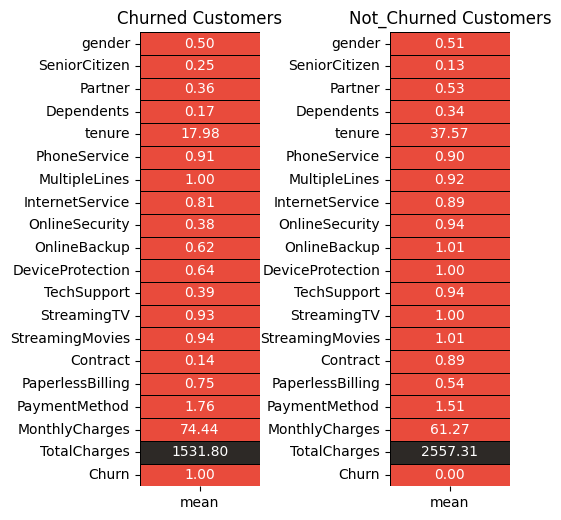

In [17]:
colors = ['#E94B3C','#2D2926']

churn = df1[df1['Churn'] == 1].describe().T
not_churn = df1[df1['Churn'] == 0].describe().T

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(churn[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Churned Customers');

plt.subplot(1,2,2)
sns.heatmap(not_churn[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f',)
plt.title('Not_Churned Customers');

fig.tight_layout(pad = 0)

In [18]:
col = list(df1.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : gender SeniorCitizen Partner Dependents PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies Contract PaperlessBilling PaymentMethod Churn
Numerical Features : tenure MonthlyCharges TotalCharges


In [19]:
data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


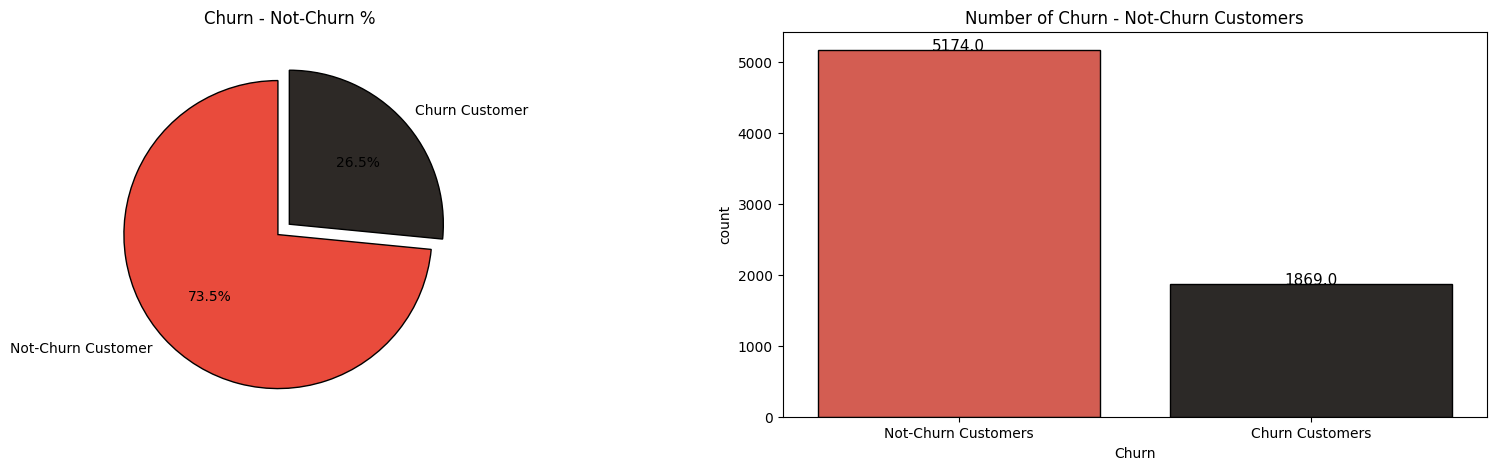

In [20]:
l = list(df1['Churn'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
plt.subplot(1,2,1)
plt.pie(circle,labels = ['Not-Churn Customer','Churn Customer'],autopct = '%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Churn - Not-Churn %');

plt.subplot(1,2,2)
ax = sns.countplot(data = data,x='Churn', palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
ax.set_xticklabels(['Not-Churn Customers','Churn Customers'])

plt.title('Number of Churn - Not-Churn Customers');
plt.show()
     

In [ ]:
categorical_features.remove('Churn')

In [ ]:
l1 = ['gender','SeniorCitizen','Partner','Dependents']
l2 = ['PhoneService','MultipleLines','InternetService','StreamingTV','StreamingMovies',
      'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport']
l3 = ['Contract','PaperlessBilling','PaymentMethod']

In [ ]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l1)):
    plt.subplot(2,2,i+1)
    ax = sns.countplot(x = l1[i],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l1[i] + ' vs Churn'
    plt.title(title);

In [ ]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(x = l2[i],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l2[i] + ' vs Churn'
    plt.title(title);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.countplot(x = l2[2],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l2[2] + ' vs Churn'
plt.title(title);

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.countplot(x = l2[i + 3],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l2[i + 3] + ' vs Churn'
    plt.title(title);

In [ ]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.countplot(x = l2[-4 + i],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
    title = l2[-4 + i] + ' vs Churn'
    plt.title(title);

In [ ]:
fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

plt.subplot(1,3,1)
ax = sns.countplot(x = l3[0],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l3[0] + ' vs Churn'
plt.title(title);

plt.subplot(1,3,2)
ax = sns.countplot(x= l3[1],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l3[1] + ' vs Churn'
plt.title(title);

plt.subplot(1,3,3)
ax = sns.countplot(x = l3[2],data = data,hue = "Churn",palette = colors,edgecolor = 'black')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
title = l3[2] + ' vs Churn'
plt.title(title);

In [ ]:
gender = df1[df1['Churn'] == 1]['gender'].value_counts()
gender = [gender[0] / sum(gender) * 100, gender[1] / sum(gender) * 100] # Female / Male

seniorcitizen = df1[df1['Churn'] == 1]['SeniorCitizen'].value_counts()
seniorcitizen = [seniorcitizen[0] / sum(seniorcitizen) * 100,seniorcitizen[1] / sum(seniorcitizen) * 100] # No - Yes

partner = df1[df1['Churn'] == 1]['Partner'].value_counts()
partner = [partner[0] / sum(partner) * 100,partner[1] / sum(partner) * 100] # No - Yes

dependents = df1[df1['Churn'] == 1]['Dependents'].value_counts()
dependents = [dependents[0] / sum(dependents) * 100,dependents[1] / sum(dependents) * 100] # No

In [ ]:
ax,fig = plt.subplots(nrows = 1,ncols = 4,figsize = (15,15))

plt.subplot(1,4,1)
plt.pie(gender,labels = ['Female','Male'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Gender');

plt.subplot(1,4,2)
plt.pie(seniorcitizen,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('SeniorCitizen');

plt.subplot(1,4,3)
plt.pie(partner,labels = ['No','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Partner');

plt.subplot(1,4,4)
plt.pie(dependents,labels = ['No','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Dependents');
     

In [ ]:
phoneservice = df1[df1['Churn'] == 1]['PhoneService'].value_counts()
phoneservice = [phoneservice[0] / sum(phoneservice) * 100, phoneservice[1] / sum(phoneservice) * 100] # No - Yes

multiplelines = df1[df1['Churn'] == 1]['MultipleLines'].value_counts()
multiplelines = [multiplelines[0] / sum(multiplelines) * 100,multiplelines[1] / sum(multiplelines) * 100, multiplelines[2] / sum(multiplelines) * 100] # No - No Phone Service - Yes

internetservice = df1[df1['Churn'] == 1]['InternetService'].value_counts()
internetservice = [internetservice[0] / sum(internetservice) * 100,internetservice[1] / sum(internetservice) * 100, internetservice[2] / sum(internetservice) * 100] # DSL - Fiber Optic - No

streamingtv = df1[df1['Churn'] == 1]['StreamingTV'].value_counts()
streamingtv = [streamingtv[0] / sum(streamingtv) * 100,streamingtv[1] / sum(streamingtv) * 100, streamingtv[2] / sum(streamingtv) * 100] # No - No Internet Service - Yes

streamingmovies = df1[df1['Churn'] == 1]['StreamingMovies'].value_counts()
streamingmovies = [streamingmovies[0] / sum(streamingmovies) * 100,streamingmovies[1] / sum(streamingmovies) * 100, streamingmovies[2] / sum(streamingmovies) * 100] # No - No Internet Service - Yes
     

In [ ]:
ax,fig = plt.subplots(nrows = 1,ncols = 2,figsize = (8,8))

plt.subplot(1,2,1)
plt.pie(phoneservice,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PhoneService');

plt.subplot(1,2,2)
plt.pie(multiplelines,labels = ['No','No Phone Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('MultipleLines');

ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (12,12))

plt.subplot(1,3,1)
plt.pie(internetservice,labels = ['DSL', 'Fiber Optic','No'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('InternetService');

plt.subplot(1,3,2)
plt.pie(streamingtv,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingTV');

plt.subplot(1,3,3)
plt.pie(streamingmovies,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingMovies');

In [ ]:
onlinesecurity = df1[df1['Churn'] == 1]['OnlineSecurity'].value_counts()
onlinesecurity = [onlinesecurity[0] / sum(onlinesecurity) * 100,onlinesecurity[1] / sum(onlinesecurity) * 100, onlinesecurity[2] / sum(onlinesecurity) * 100] # No - No Internet Service - Yes

onlinebackup = df1[df1['Churn'] == 1]['OnlineBackup'].value_counts()
onlinebackup = [onlinebackup[0] / sum(onlinebackup) * 100,onlinebackup[1] / sum(onlinebackup) * 100, onlinebackup[2] / sum(onlinebackup) * 100] # No - No Internet Service - Yes

deviceprotection = df1[df1['Churn'] == 1]['DeviceProtection'].value_counts()
deviceprotection = [deviceprotection[0] / sum(deviceprotection) * 100,deviceprotection[1] / sum(deviceprotection) * 100, deviceprotection[2] / sum(deviceprotection) * 100] # No - No Internet Service - Yes

techsupport = df1[df1['Churn'] == 1]['TechSupport'].value_counts()
techsupport = [techsupport[0] / sum(techsupport) * 100,techsupport[1] / sum(techsupport) * 100, techsupport[2] / sum(techsupport) * 100] # No - No Internet Service - Yes
     

In [ ]:
ax,fig = plt.subplots(nrows = 1,ncols = 4,figsize = (15,15))

plt.subplot(1,4,1)
plt.pie(onlinesecurity,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('OnlineSecurity');

plt.subplot(1,4,2)
plt.pie(onlinebackup,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('OnlineBackup');

plt.subplot(1,4,3)
plt.pie(deviceprotection,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('DeviceProtection');

plt.subplot(1,4,4)
plt.pie(techsupport,labels = ['No', 'No Internet Service','Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('TechSupport');
     

In [ ]:
contract = df1[df1['Churn'] == 1]['Contract'].value_counts()
contract = [contract[0] / sum(contract) * 100, contract[1] / sum(contract) * 100, contract[2] / sum(contract) * 100] # Month-to-month - One year - Two year

paperlessbilling = df1[df1['Churn'] == 1]['PaperlessBilling'].value_counts()
paperlessbilling = [paperlessbilling[0] / sum(paperlessbilling) * 100,paperlessbilling[1] / sum(paperlessbilling) * 100] # No - Yes

paymentmethod = df1[df1['Churn'] == 1]['PaymentMethod'].value_counts()
paymentmethod = [paymentmethod[0] / sum(paymentmethod) * 100, paymentmethod[1] / sum(paymentmethod) * 100,
            paymentmethod[2] / sum(paymentmethod) * 100, paymentmethod[3] / sum(paymentmethod) * 100]
            # Bank Transfer (automatic) - Credit Card (automatic) - Electronic check - Mailed check
     

In [ ]:
ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (12,12))

plt.subplot(1,3,1)
plt.pie(contract,labels = ['Month-to-month','One year','Two year'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0.1,0.1),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Contract');

plt.subplot(1,3,2)
plt.pie(paperlessbilling,labels = ['No', 'Yes'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PaperlessBilling');

plt.subplot(1,3,3)
plt.pie(paymentmethod,labels = ['Bank Transfer (automatic)','Credit Card (automatic)','Electronic check','Mailed check'],autopct='%1.1f%%',startangle = 90,explode = (0.1,0,0.1,0),colors = colors,
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('PaymentMethod');
     

In [ ]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i in range(len(numerical_features)):
    plt.subplot(1,3,i+1)
    sns.distplot(df1[numerical_features[i]],color = colors[0])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()
     

In [ ]:
fig, ax = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))
for i in range(len(numerical_features)):
    plt.subplot(3,1,i+1)
    sns.countplot(x = numerical_features[i],data = df1,hue = "Churn",palette = colors,edgecolor = 'black')
    plt.legend(['No Churn','Churn'],loc = 'upper left')
    title = numerical_features[i] + ' w.r.t Churn'
    plt.title(title);
     


In [ ]:

df1['MonthlyCharges_Group'] = [int(i / 5) for i in df1['MonthlyCharges']]
df1['TotalCharges_Group'] = [int(i / 500) for i in df1['TotalCharges']]

fig, ax = plt.subplots(nrows = 2,ncols = 1,figsize = (20,10))
for i in range(len(numerical_features[1:])):
    plt.subplot(2,1,i+1)
    sns.countplot(x = numerical_features[1 + i]+'_Group',data = df1,hue = "Churn",palette = colors,edgecolor = 'black')
    plt.legend(['No Churn','Churn'],loc = 'upper left')
    title = numerical_features[1 + i] + ' w.r.t Churn'
    plt.title(title);
     

In [ ]:

fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = l1[i],y = 'tenure',data = data,hue = 'Churn',palette = colors);
    plt.title('tenure vs ' + l1[i]);

In [ ]:

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i],y = 'tenure',data = data,hue = 'Churn',palette = colors);
    plt.title('tenure vs ' + l2[i]);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = l2[2],y = 'tenure',data = data,hue = 'Churn',palette = colors);
plt.title('tenure vs ' + l2[2]);

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i + 3],y = 'tenure',data = data,hue = 'Churn',palette = colors);
    plt.title('tenure vs ' + l2[i + 3]);

In [ ]:

fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = l2[i - 4],y = 'tenure',data = data,hue = 'Churn',palette = colors);
    plt.title('tenure vs ' + l2[i-4]);

In [ ]:

fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))
for i in range(len(l3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = l3[i],y = 'tenure',data = data,hue = 'Churn',palette = colors);
    plt.title('tenure vs ' + l3[i]);

In [ ]:

fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = l1[i],y = 'MonthlyCharges',data = data,hue = 'Churn',palette = colors);
    plt.title('MonthlyCharges vs ' + l1[i]);

In [ ]:

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i],y = 'MonthlyCharges',data = data,hue = 'Churn',palette = colors);
    plt.title('MonthlyCharges vs ' + l2[i]);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = l2[2],y = 'MonthlyCharges',data = data,hue = 'Churn',palette = colors);
plt.title('MonthlyCharges vs ' + l2[2]);

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i + 3],y = 'MonthlyCharges',data = data,hue = 'Churn',palette = colors);
    plt.title('MonthlyCharges vs ' + l2[i + 3]);

In [ ]:

fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = l2[i - 4],y = 'MonthlyCharges',data = data,hue = 'Churn',palette = colors);
    plt.title('MonthlyCharges vs ' + l2[i-4]);
     

In [ ]:

fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

for i in range(len(l3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = l3[i],y = 'MonthlyCharges',data = data,hue = 'Churn',palette = colors);
    title = 'MonthlyCharges vs ' + l3[i]
    plt.title(title);

In [ ]:

fig = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    ax = sns.boxplot(x = l1[i],y = 'TotalCharges',data = data,hue = 'Churn',palette = colors);
    plt.title('TotalCharges vs ' + l1[i]);

In [ ]:

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (15,5))

for i in range(len(l2[0:2])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i],y = 'TotalCharges',data = data,hue = 'Churn',palette = colors);
    plt.title('TotalCharges vs ' + l2[i]);

fig = plt.subplots(nrows = 1, ncols = 1, figsize = (6,5))

plt.subplot(1,1,1)
ax = sns.boxplot(x = l2[2],y = 'TotalCharges',data = data,hue = 'Churn',palette = colors);
plt.title('TotalCharges vs ' + l2[2]);

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (12,5))

for i in range(len(l2[3:5])):
    plt.subplot(1,2,i + 1)
    ax = sns.boxplot(x = l2[i + 3],y = 'TotalCharges',data = data,hue = 'Churn',palette = colors);
    plt.title('TotalCharges vs ' + l2[i + 3]);

In [ ]:
fig = plt.subplots(nrows = 2,ncols = 2,figsize = (20,14))
for i in range(len(l2[-4:])):
    plt.subplot(2,2,i + 1)
    ax = sns.boxplot(x = l2[i - 4],y = 'TotalCharges',data = data,hue = 'Churn',palette = colors);
    plt.title('TotalCharges vs ' + l2[i-4]);
     

In [ ]:

fig = plt.subplots(nrows = 1,ncols = 3,figsize = (25,7))

for i in range(len(l3)):
    plt.subplot(1,3,i + 1)
    ax = sns.boxplot(x = l3[i],y = 'TotalCharges',data = data,hue = 'Churn',palette = colors);
    plt.title('TotalCharges vs ' + l3[i]);

In [ ]:

a = 0
fig,ax = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))
for i in range(len(numerical_features)):
    for j in range(len(numerical_features)):
        if i != j and j > i:
            a += 1
            plt.subplot(3,1,a)
            sns.scatterplot(x = numerical_features[i],y = numerical_features[j],data = df1,hue = 'Churn',palette = colors,edgecolor = 'black');
            plt.legend(['No Churn','Churn'],loc = 'upper left',)
            title = numerical_features[i] + ' vs ' + numerical_features[j]
            plt.title(title)

In [ ]:

from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1.drop(columns = ['MonthlyCharges_Group','TotalCharges_Group'], inplace = True)

df1['tenure'] = mms.fit_transform(df1[['tenure']])
df1['MonthlyCharges'] = mms.fit_transform(df1[['MonthlyCharges']])
df1['TotalCharges'] = mms.fit_transform(df1[['TotalCharges']])
df1.head()
     

In [ ]:

plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),cmap = colors,annot = True);

In [ ]:
corr = df1.corrwith(df1['Churn']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t Outcome');
     

In [ ]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif

In [ ]:

features = df1.loc[:,categorical_features]
target = df1.loc[:,'Churn']

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features');
     

In [ ]:

from sklearn.feature_selection import f_classif

In [ ]:

features = df1.loc[:,numerical_features]
target = df1.loc[:,'Churn']

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score'])

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

In [ ]:

df1.drop(columns = ['PhoneService', 'gender','StreamingTV','StreamingMovies','MultipleLines','InternetService'],inplace = True)
df1.head()

In [ ]:

import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:

over = SMOTE(sampling_strategy = 1)

f1 = df1.iloc[:,:13].values
t1 = df1.iloc[:,13].values

f1, t1 = over.fit_resample(f1, t1)
Counter(t1)
     

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(f1, t1, test_size = 0.20, random_state = 2)


In [ ]:
def model(classifier,x_train,y_train,x_test,y_test):

    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    RocCurveDisplay.from_estimator(classifier, x_test,y_test)
    plt.title('ROC_AUC_Plot')
    plt.show()

def model_evaluation(classifier,x_test,y_test):

    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')

    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

In [ ]:
from xgboost import XGBClassifier

classifier_xgb = XGBClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

In [ ]:
model(classifier_xgb,x_train,y_train,x_test,y_test)


In [ ]:
model_evaluation(classifier_xgb,x_test,y_test)


In [ ]:
from lightgbm import LGBMClassifier

classifier_lgbm = LGBMClassifier(learning_rate= 0.01,max_depth = 3,n_estimators = 1000)

In [ ]:
model(classifier_lgbm,x_train,y_train,x_test,y_test)


In [ ]:
model_evaluation(classifier_lgbm,x_test,y_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(max_depth = 4,random_state = 0)
model(classifier_rf,x_train,y_train,x_test,y_test)

In [ ]:
model_evaluation(classifier_rf,x_test,y_test)


In [ ]:

from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)
model(classifier_dt,x_train,y_train,x_test,y_test)

In [ ]:
model_evaluation(classifier_dt,x_test,y_test)


In [ ]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators = [('classifier_xgb',classifier_xgb),
                                         ('classifier_lgbm',classifier_lgbm),
                                         ('classifier_rf',classifier_rf),
                                         ('classifier_dt',classifier_dt)],
                           final_estimator = classifier_lgbm)

In [ ]:
model(stack,x_train,y_train,x_test,y_test)


In [ ]:
model_evaluation(stack,x_test,y_test)
